In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'  # default is ‘last_expr’

%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/wcs/pycharm')
sys.path.append('/yasiyu/repos/ai4eutils')

In [3]:
import os
os.getcwd()

'/home/boto/notebooks/wcs/data'

In [4]:
import os

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage import img_as_ubyte
import torch
import torchvision.transforms as transforms
print(torch.__version__)

# now ai4eutils is on the path
from geospatial.visualization.raster_label_visualizer import RasterLabelVisualizer
from geospatial.visualization.imagery_visualizer import ImageryVisualizer

from training.scripts_and_config.utils.datasets import LandsatDataset, SingleShardChipsDataset
from training.scripts_and_config.utils.data_transforms import ToTensor, RandomHorizontalFlip, RandomVerticalFlip

1.5.1


In [7]:
import training.experiments.coarse_baseline.coarse_baseline_config_refactored as config

Weights on loss per class used:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
For prefix train, loaded chips of dims (6012, 6, 256, 256), labels of dims (6012, 256, 256)
For prefix val, loaded chips of dims (679, 6, 256, 256), labels of dims (679, 256, 256)


In [8]:
label_viz = config.label_viz

# Test the IterableDataset implementation

use `training/experiments/elevation/elevation_2_config.py` as config

In [9]:
dataset = config.dset_train

In [10]:
dataset_items = []
for i, item in enumerate(dataset):
    dataset_items.append(item)
    if i > 200:
        break

In [11]:
len(dataset_items)

202

Looked at the problematic chips... The non-zero ones are bands 6 and 7 (SWIR). Not sure why they are non-zero...

## Inspect tiles and their label masks

torch.Size([6, 256, 256])
torch.Size([256, 256])


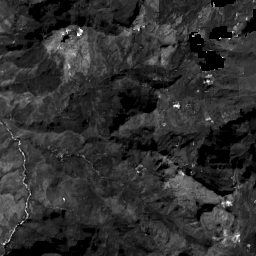

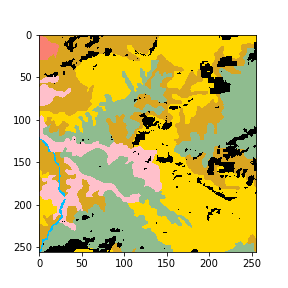

torch.Size([6, 256, 256])
torch.Size([256, 256])


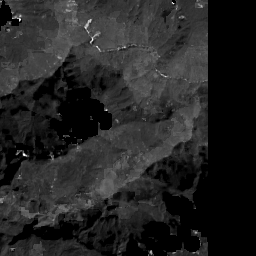

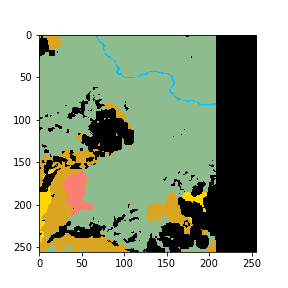

torch.Size([6, 256, 256])
torch.Size([256, 256])


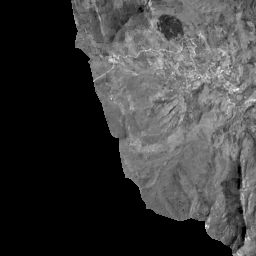

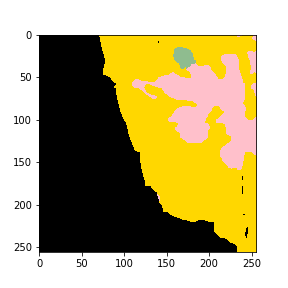

torch.Size([6, 256, 256])
torch.Size([256, 256])


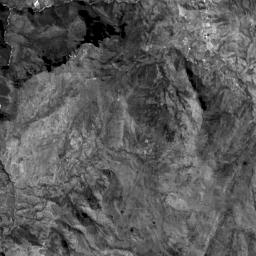

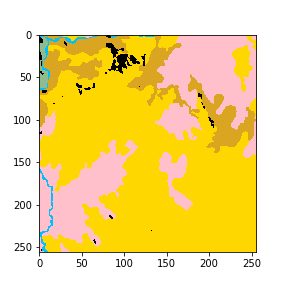

torch.Size([6, 256, 256])
torch.Size([256, 256])


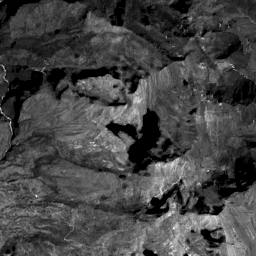

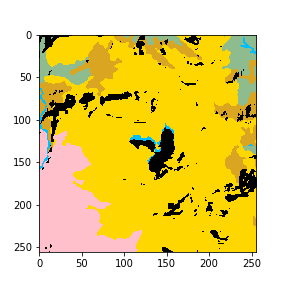

torch.Size([6, 256, 256])
torch.Size([256, 256])


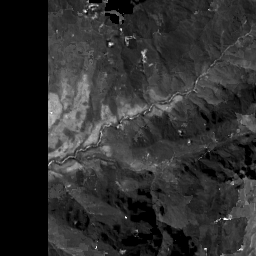

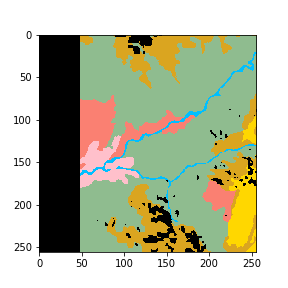

torch.Size([6, 256, 256])
torch.Size([256, 256])


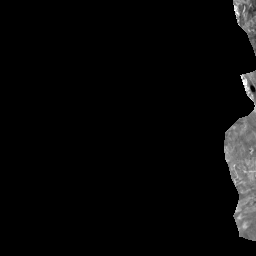

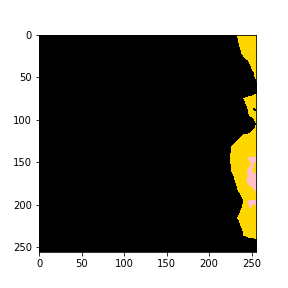

torch.Size([6, 256, 256])
torch.Size([256, 256])


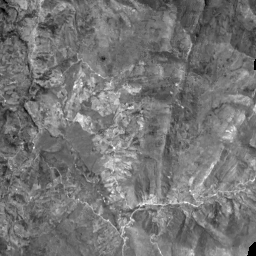

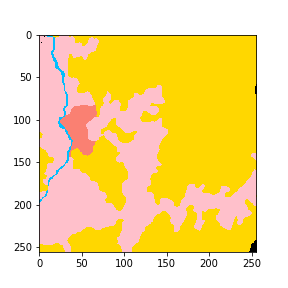

torch.Size([6, 256, 256])
torch.Size([256, 256])


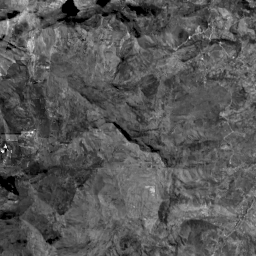

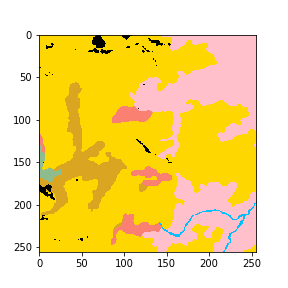

torch.Size([6, 256, 256])
torch.Size([256, 256])


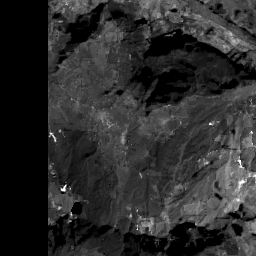

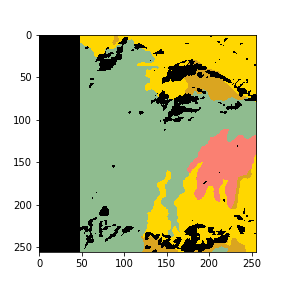

In [16]:
for item in dataset_items[35:45]:
    chip = item['chip']
    label = item['chip_label']

    print(chip.shape)
    print(label.shape)
    
    chip_channel_0 = Image.fromarray(img_as_ubyte(chip[0, :, :]))
    chip_channel_0
    
    label, buf = label_viz.show_label_raster(label_raster=label, size=(4, 4))
    label

## Horizontal and vertical flips

tensor(43209.8359)
torch.Size([6, 256, 200])
torch.Size([256, 200, 3])
torch.Size([256, 200])
original pixel val: 0.0


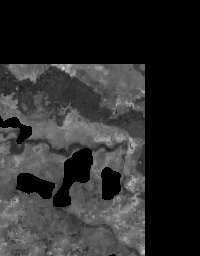

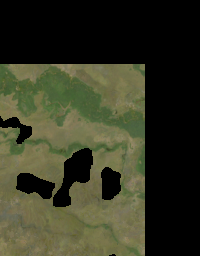

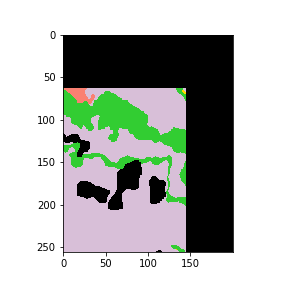

Horizontal flip
torch.Size([6, 256, 200])
hflipped pixel val: 0.0


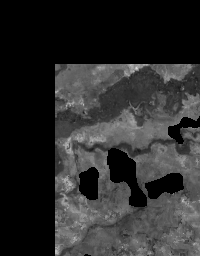

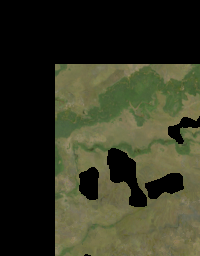

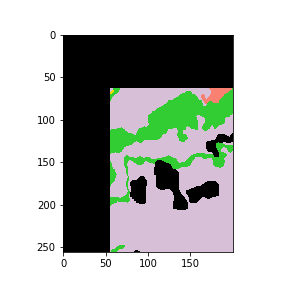

Vertical flip
torch.Size([6, 256, 200])
vflipped pixel val: 0.4724999964237213


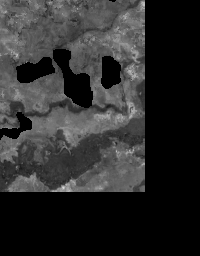

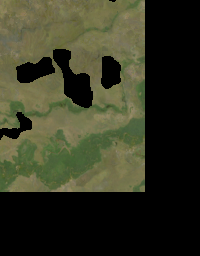

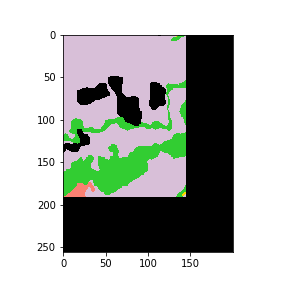

tensor(109151.1406)
torch.Size([6, 256, 200])
torch.Size([256, 200, 3])
torch.Size([256, 200])
original pixel val: 0.4779999852180481


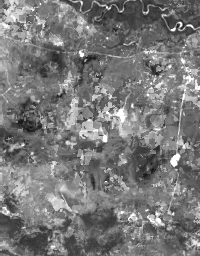

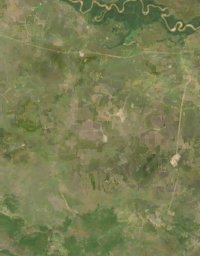

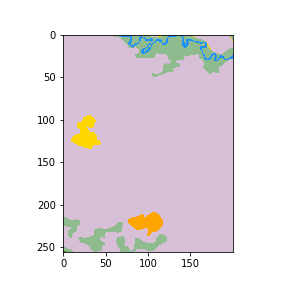

Horizontal flip
torch.Size([6, 256, 200])
hflipped pixel val: 0.33399999141693115


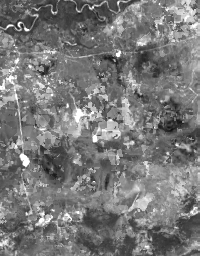

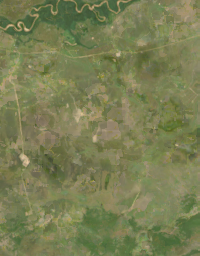

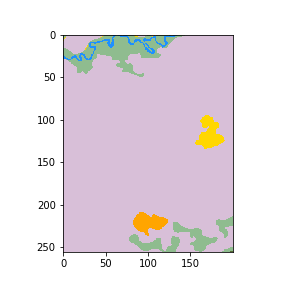

Vertical flip
torch.Size([6, 256, 200])
vflipped pixel val: 0.25099998712539673


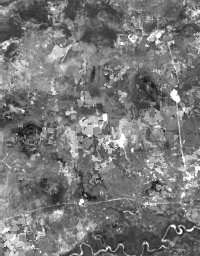

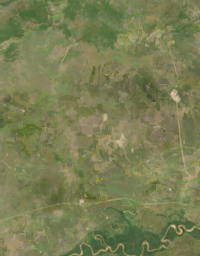

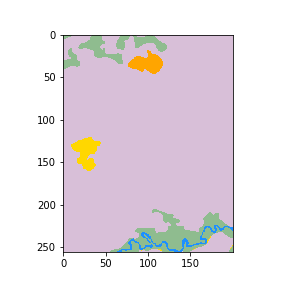

In [40]:
new_width = 200

for item in dataset_items[198:200]:
    image_id = item['chip_id']
    chip = item['chip']
    label = item['chip_label']
    chip_display = item['chip_for_display']
    
    # make rectangular to make sure H and W are flipped correctly
    chip = chip[:, :, :new_width]
    label = label[:, :new_width]
    chip_display = chip_display[:, :new_width, :]

    print(chip.sum())
    print(chip.shape)
    print(chip_display.shape)
    print(label.shape)
    
    print(f'original pixel val: {chip[3, 3, 3]}')
    chip_channel_0 = Image.fromarray(img_as_ubyte(chip[0, :, :]))
    chip_channel_0
    
    im = Image.fromarray(img_as_ubyte(chip_display))
    im
    
    label_rendered, buf = viz_util.show_label_raster(label, size=(4, 4))
    label_rendered
    
    
    print('Horizontal flip - flip along width dim')
    
    chip_flipped = torch.flip(chip, [2])  # chip is of dim channel, height, width
    print(chip_flipped.shape)
    print(f'hflipped pixel val: {chip_flipped[3, 3, 3]}')
    chip_channel_0 = Image.fromarray(img_as_ubyte(chip_flipped[0, :, :]))
    chip_channel_0
    
    chip_display_flipped = torch.flip(chip_display, [1])  # chip_display is of dim height, width, channel
    im_flipped = Image.fromarray(img_as_ubyte(chip_display_flipped))
    im_flipped
    
    label_flipped = torch.flip(label, [1])
    label_rendered, buf = viz_util.show_label_raster(label_flipped, size=(4, 4))
    label_rendered
    
    
    print('Vertical flip - flip along height dim')
    
    chip_flipped = torch.flip(chip, [1])
    print(chip_flipped.shape)
    print(f'vflipped pixel val: {chip_flipped[3, 3, 3]}')
    chip_channel_0 = Image.fromarray(img_as_ubyte(chip_flipped[0, :, :]))
    chip_channel_0
    
    chip_display_flipped = torch.flip(chip_display, [0])
    im_flipped = Image.fromarray(img_as_ubyte(chip_display_flipped))
    im_flipped
    
    label_flipped = torch.flip(label, [0])
    label_rendered, buf = viz_util.show_label_raster(label_flipped, size=(4, 4))
    label_rendered

### Possible confusion with PIL height and width positions

In [43]:
im_flipped.size  # (width, height)

np.array(im_flipped).shape  # (height, width, channel)

(200, 256)

(256, 200, 3)

# Check the sharded numpy arrays of chips

In [9]:
data_dir = '/boto_disk_0/wcs_data/shards/full_sr_median_2013_2014_elevation'

In [22]:
train_chips_0 = np.load(os.path.join(data_dir, 'val_chips_0.npy'))

In [23]:
train_chips_0.shape

(679, 6, 256, 256)

In [24]:
train_labels_0 = np.load(os.path.join(data_dir, 'val_labels_0.npy'))

In [25]:
train_labels_0.shape

(679, 256, 256)

In [26]:
len(train_chips_0)

679

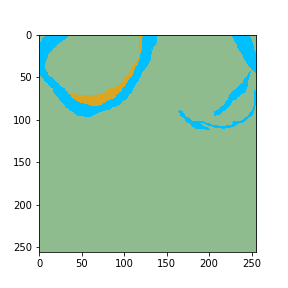

Band 2


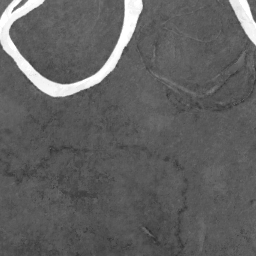

Band 3


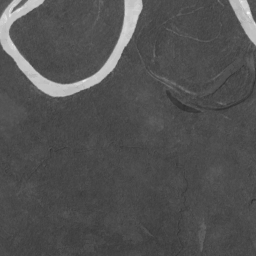

Band 6


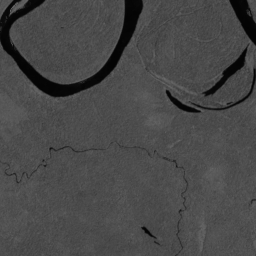

Band 7


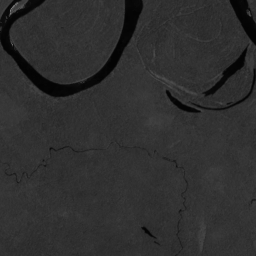

Band  NDVI


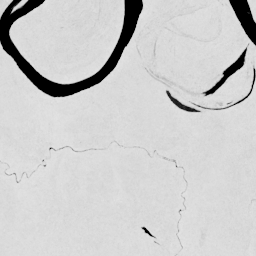

Elevation


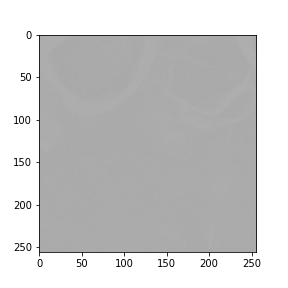

In [28]:
chip_idx = 600

label_rendered, buf = viz_util.show_label_raster(train_labels_0[chip_idx, :, :], size=(4, 4))
label_rendered

print('Band 2')
chip_channel_2 = Image.fromarray(img_as_ubyte(train_chips_0[chip_idx, 0, :, :]))
chip_channel_2

print('Band 3')
chip_channel_3 = Image.fromarray(img_as_ubyte(train_chips_0[chip_idx, 1, :, :]))
chip_channel_3

print('Band 6')
chip_channel_6 = Image.fromarray(img_as_ubyte(train_chips_0[chip_idx, 2, :, :]))
chip_channel_6

print('Band 7')
chip_channel_7 = Image.fromarray(img_as_ubyte(train_chips_0[chip_idx, 3, :, :]))
chip_channel_7

print('Band  NDVI')
chip_channel_ndvi = Image.fromarray(img_as_ubyte(train_chips_0[chip_idx, 4, :, :]))
chip_channel_ndvi

print('Elevation')
elevation = train_chips_0[chip_idx, 5, :, :]
im, buf = viz_util.show_single_band(elevation, size=(4, 4))
im

In [29]:
band_comb = (2, 1, 0)  # bands 6, 3, 2
ndvi_band = 4
elevation_band = 5

In [30]:
# dims is (num_chips, channels, height, width)

train_chips_0[0, band_comb, :, :].shape

(3, 256, 256)

Band 6, 3, 2


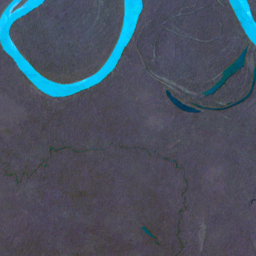

In [31]:
print('Band 6, 3, 2')
bands_to_show = train_chips_0[chip_idx, band_comb, :, :]
bands_to_show = np.transpose(bands_to_show, axes=(1, 2, 0))
chip_channel_2 = Image.fromarray(img_as_ubyte(bands_to_show))
chip_channel_2

In [32]:
bands_to_show.min()
bands_to_show.max()

0.0128

1.0

In [33]:
for i, sample in enumerate(train_chips_0):
    
    a = sample[band_comb, :, :]
    
    if a.min() < 0:
        print(i)
        print(a.min())
    if a.max() > 1.0:
        print(i)
        print(a.max())

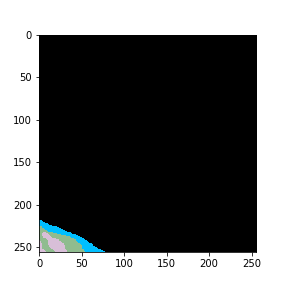

In [34]:
for label_mask in train_labels_0:
    im, buf = viz_util.show_label_raster(label_mask, size=(4, 4))
    im
    break

# Check SingleShardChipsDataset

In [97]:
data_shard_dir = '/boto_disk_0/wcs_data/shards/full_sr_median_2013_2014_elevation'

In [115]:
dset_train = SingleShardChipsDataset(data_shard_dir, shard_prefix='train', channels=None,
                            transform=transforms.Compose([
                                ToTensor(),
                                RandomHorizontalFlip(),  # these operate on Tensors, not PIL images
                                RandomVerticalFlip()
                            ]))

For prefix train, loaded chips of dims (6012, 6, 256, 256), labels of dims (6012, 256, 256)


In [116]:
dataset = dset_train

num_to_skip = 5  # first few chips might be mostly blank
assert len(dataset) > num_to_skip + config.num_chips_to_viz

keep_every = math.floor((len(dataset) - num_to_skip) / 48)

images_list = []  # for display
image_tensors = []  # as input to model
labels_list = []

sample_idx = range(num_to_skip, len(dataset), keep_every)

image_tensors = dataset[sample_idx]

In [117]:
type(image_tensors)

dict

In [118]:
image_tensors.keys()

dict_keys(['chip', 'chip_label'])

In [119]:
image_tensors['chip'].shape

torch.Size([49, 6, 256, 256])

In [120]:
image_tensors['chip_label'].shape

torch.Size([49, 256, 256])

In [121]:
dataset[0]['chip_label'].dtype

torch.int64